#Sentiment Analysis Twitter with [snscrape] and [vader]

Referensi :

*   https://www.youtube.com/watch?v=jtIMnmbnOFo
*   https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d


## Install Modules and Import Library

In [ ]:
!pip install textblob
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# data scraping
import snscrape.modules.twitter as sntwitter

# sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# chart
import matplotlib.pyplot as plt

# data cleaning
import re
import string

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Data Scraping

Library = `snscrape`

data scraping twitter menurut search keyword \
Time Range = 1 Januari 2022 - 20 April 2022 \
Keyword =
*   ui ux
*   python

Hasil data scraping akan disimpan di runtime ini

Karena proses run lama, gapapa kalo section ini gausah di run lagi. Langsung import dataset hasil scraping di section bawahnya


# **Python**

In [ ]:
# Scraping Python
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_python.csv')

## Sentiment Keyword = Python

### Import Dataset

In [ ]:
#import dataset python
url='https://drive.google.com/file/d/1SsRJ5CDyM776iHhpVu9LKDRxXjAyn_YG/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "python lang:id since:2022-01-01"

python = pd.read_csv(file_name)
python.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 23:46:03+00:00,Jokitugsfess,Joktug! Joki coding python membuat GUI
1,1,2022-04-19 19:41:43+00:00,ronald_kaseke,@OswellMunemo @magumbo_wacho @Yvie_Bae @Faffie...
2,2,2022-04-19 16:57:16+00:00,muhdaniellll,Lepas guna python. Rasa macam Java ni programm...
3,3,2022-04-19 16:56:46+00:00,orcql,@Akbar10Ward Blajar data lu bar? Welcome to du...
4,4,2022-04-19 16:35:01+00:00,bapaknyakucing,"Iseng2 coba develop bikin instagram chatbot, n..."


In [ ]:
python.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4725 non-null   int64 
 1   Date        4725 non-null   object
 2   User        4725 non-null   object
 3   Tweet       4725 non-null   object
dtypes: int64(1), object(3)
memory usage: 147.8+ KB


### Data Preprocessing

*   Menghapus Row yang Null
*   menghapus Row yang sama (duplicate row)
*   Memfilter Retweet, tag, dan link
*   Mengubah Tweet ke dalam bentuk lowercase
*   Menghapus Kolom yang tidak digunakan



In [ ]:
tw_list = python

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 23:46:03+00:00,Jokitugsfess,joktug! joki coding python membuat gui,Joktug! Joki coding python membuat GUI
1,1,2022-04-19 19:41:43+00:00,ronald_kaseke,ndanga ndichimbozama kuita python style,@OswellMunemo @magumbo_wacho @Yvie_Bae @Faffie...
2,2,2022-04-19 16:57:16+00:00,muhdaniellll,lepas guna python. rasa macam java ni programm...,Lepas guna python. Rasa macam Java ni programm...
3,3,2022-04-19 16:56:46+00:00,orcql,blajar data lu bar? welcome to dunia python w...,@Akbar10Ward Blajar data lu bar? Welcome to du...
4,4,2022-04-19 16:35:01+00:00,bapaknyakucing,"iseng2 coba develop bikin instagram chatbot, n...","Iseng2 coba develop bikin instagram chatbot, n..."


Note :

[Tweet] = Hasil Filter \
[text] = Raw Tweet

In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

### Sentiment Analysis

Library = vader

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0

# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 23:46:03+00:00,Jokitugsfess,joktug! joki coding python membuat gui,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,2022-04-19 19:41:43+00:00,ronald_kaseke,ndanga ndichimbozama kuita python style,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,2022-04-19 16:57:16+00:00,muhdaniellll,lepas guna python. rasa macam java ni programm...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
3,2022-04-19 16:56:46+00:00,orcql,blajar data lu bar? welcome to dunia python w...,0.800000,0.900000,positive,0.000,0.727,0.273,0.4588
4,2022-04-19 16:35:01+00:00,bapaknyakucing,"iseng2 coba develop bikin instagram chatbot, n...",0.000000,0.000000,positive,0.000,0.874,0.126,0.3182
5,2022-04-19 16:15:49+00:00,Jokitugsfess,joktug! need joki pemrograman metnum bahasa py...,0.000000,0.000000,negative,0.210,0.790,0.000,-0.3382
6,2022-04-19 15:56:04+00:00,Aprxty,for enteprise yo java. karna ada sertifikasin...,0.300000,0.200000,positive,0.000,0.752,0.248,0.5106
7,2022-04-19 15:48:37+00:00,sagaruxee,skrg 2 bahasa terseru menurutku python sm php,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
8,2022-04-19 15:42:45+00:00,codingfess,mending belajar java dlu ato python ya? code;,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
9,2022-04-19 14:21:42+00:00,Ebedkm,cses 1633 dicoba pake python dp top down maupu...,0.172222,0.394444,positive,0.074,0.820,0.107,0.0516


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-04-19 16:56:46+00:00,orcql,blajar data lu bar? welcome to dunia python w...,0.8,0.9,positive,0.0,0.727,0.273,0.4588
4,2022-04-19 16:35:01+00:00,bapaknyakucing,"iseng2 coba develop bikin instagram chatbot, n...",0.0,0.0,positive,0.0,0.874,0.126,0.3182
6,2022-04-19 15:56:04+00:00,Aprxty,for enteprise yo java. karna ada sertifikasin...,0.3,0.2,positive,0.0,0.752,0.248,0.5106


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
5,2022-04-19 16:15:49+00:00,Jokitugsfess,joktug! need joki pemrograman metnum bahasa py...,0.0,0.0,negative,0.210,0.790,0.0,-0.3382
30,2022-04-19 03:18:25+00:00,algonacci,"klo di python dan pake mongodb, ada pymongo j...",0.0,0.0,negative,0.177,0.823,0.0,-0.4215
31,2022-04-19 02:45:52+00:00,Jokitugsfess,"yang pinter pemrograman khususnya python, aku ...",0.0,0.0,negative,0.123,0.877,0.0,-0.3382


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 23:46:03+00:00,Jokitugsfess,joktug! joki coding python membuat gui,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-19 19:41:43+00:00,ronald_kaseke,ndanga ndichimbozama kuita python style,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-19 16:57:16+00:00,muhdaniellll,lepas guna python. rasa macam java ni programm...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,313,6.62
positive,640,13.54
neutral,3772,79.83


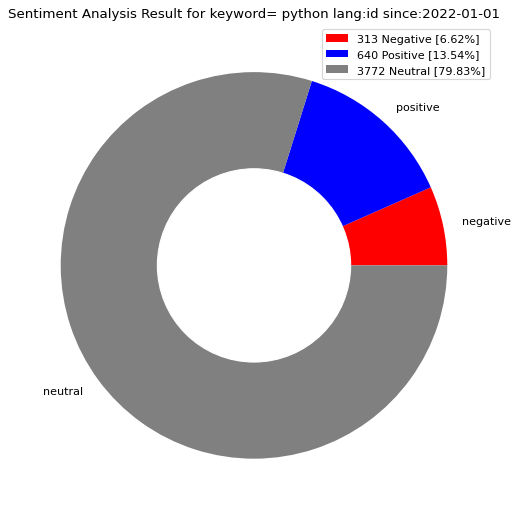

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kursus Python**

In [ ]:
query = "kursus python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kursuspython.csv')

In [ ]:
url='https://drive.google.com/file/d/1t0JlVRh26KtEMLi16pOa_cmsAV0Y94HF/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kursus python lang:id since:2022-01-01"

kursusPython = pd.read_csv(file_name)
kursusPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-16 11:05:18+00:00,areumswan,@worksfess Mauuu nderrrrr kerjaan impian gua i...
1,1,2022-04-16 10:47:36+00:00,itseimrld,"@worksfess Hi Senderrr, menarik nih, bolh tahu..."
2,2,2022-04-16 07:13:20+00:00,ittkia_,@worksfess Kak aku mau coba boleh? Mau dm juga...
3,3,2022-04-11 12:50:59+00:00,zulfikar_ozil,Saya telah mendapatkan sertifikat dari Progate...
4,4,2022-04-11 01:31:21+00:00,euclaeptus,@5eijatachi bisa cari kursus di u/de/my kannya...


In [ ]:
kursusPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16 non-null     int64 
 1   Date        16 non-null     object
 2   User        16 non-null     object
 3   Tweet       16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes


In [ ]:
tw_list = kursusPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-16 11:05:18+00:00,areumswan,mauuu nderrrrr kerjaan impian gua ini sejak i...,@worksfess Mauuu nderrrrr kerjaan impian gua i...
1,1,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...","@worksfess Hi Senderrr, menarik nih, bolh tahu..."
2,2,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,@worksfess Kak aku mau coba boleh? Mau dm juga...
3,3,2022-04-11 12:50:59+00:00,zulfikar_ozil,saya telah mendapatkan sertifikat dari progate...,Saya telah mendapatkan sertifikat dari Progate...
4,4,2022-04-11 01:31:21+00:00,euclaeptus,"bisa cari kursus di u/de/my kannyaaa, sering ...",@5eijatachi bisa cari kursus di u/de/my kannya...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 11:05:18+00:00,areumswan,mauuu nderrrrr kerjaan impian gua ini sejak i...,0.000,0.000,positive,0.0,0.930,0.070,0.0516
1,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...",0.000,0.000,positive,0.0,0.935,0.065,0.3612
2,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,0.000,0.000,positive,0.0,0.916,0.084,0.3182
3,2022-04-11 12:50:59+00:00,zulfikar_ozil,saya telah mendapatkan sertifikat dari progate...,0.000,0.000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-11 01:31:21+00:00,euclaeptus,"bisa cari kursus di u/de/my kannyaaa, sering ...",0.000,0.000,neutral,0.0,1.000,0.000,0.0000
5,2022-04-06 03:18:30+00:00,FSyah1111,"contoh, ambil kursus terpisah ttg excel/sprea...",-0.125,0.375,neutral,0.0,1.000,0.000,0.0000
6,2022-04-06 03:16:09+00:00,FSyah1111,gw dah ambil dr google.\n\nhmmm kurang banget...,0.500,0.500,neutral,0.0,1.000,0.000,0.0000
7,2022-03-02 03:35:57+00:00,iadzroi,"mulai tahun 2006-2012 hobi ngoding, sampai kur...",0.000,0.000,neutral,0.0,1.000,0.000,0.0000
8,2022-02-23 07:48:24+00:00,3rD_Kano,nitip koh barangkali buka kursus bahasa python,0.000,0.000,neutral,0.0,1.000,0.000,0.0000
9,2022-02-18 16:13:45+00:00,syarifarsyah,"thanks progate, saya telah mendapatkan sertifi...",0.250,0.200,positive,0.0,0.790,0.210,0.4926


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 11:05:18+00:00,areumswan,mauuu nderrrrr kerjaan impian gua ini sejak i...,0.0,0.0,positive,0.0,0.930,0.070,0.0516
1,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...",0.0,0.0,positive,0.0,0.935,0.065,0.3612
2,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,0.0,0.0,positive,0.0,0.916,0.084,0.3182


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-04-11 12:50:59+00:00,zulfikar_ozil,saya telah mendapatkan sertifikat dari progate...,0.000,0.000,neutral,0.0,1.0,0.0,0.0
4,2022-04-11 01:31:21+00:00,euclaeptus,"bisa cari kursus di u/de/my kannyaaa, sering ...",0.000,0.000,neutral,0.0,1.0,0.0,0.0
5,2022-04-06 03:18:30+00:00,FSyah1111,"contoh, ambil kursus terpisah ttg excel/sprea...",-0.125,0.375,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,7,43.75
neutral,9,56.25


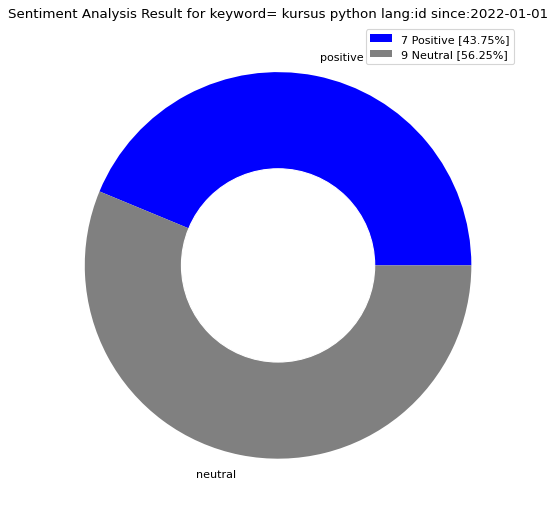

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']

pos = pc['Total']['positive']
neu = pc['Total']['neutral']

names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Python Course**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "python course lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_pythoncourse.csv')

In [ ]:
url='https://drive.google.com/file/d/1deBX6JGBNJ8IwLEbsBMe3-lAKT7ahA8Q/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "python course lang:id since:2022-01-01"

Pythoncourse = pd.read_csv(file_name)
Pythoncourse.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-16 10:47:36+00:00,itseimrld,"@worksfess Hi Senderrr, menarik nih, bolh tahu..."
1,1,2022-04-16 07:14:41+00:00,autumnn623,Enek bgt nontonin course intro datascience in ...
2,2,2022-04-16 05:04:25+00:00,detohlikaatapoh,@worksfess Belajarnya mostly dari online2 cour...
3,3,2022-04-13 11:06:07+00:00,StrayB0m,"@akbgryrt OALAAH, tp ini gua lg course python ..."
4,4,2022-04-13 09:25:00+00:00,worksfess,Work! Klo beli course datacamp buat belajar sq...


In [ ]:
Pythoncourse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  66 non-null     int64 
 1   Date        66 non-null     object
 2   User        66 non-null     object
 3   Tweet       66 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.2+ KB


In [ ]:
tw_list = Pythoncourse

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...","@worksfess Hi Senderrr, menarik nih, bolh tahu..."
1,1,2022-04-16 07:14:41+00:00,autumnn623,enek bgt nontonin course intro datascience in ...,Enek bgt nontonin course intro datascience in ...
2,2,2022-04-16 05:04:25+00:00,detohlikaatapoh,belajarnya mostly dari online2 course gratisa...,@worksfess Belajarnya mostly dari online2 cour...
3,3,2022-04-13 11:06:07+00:00,StrayB0m,"oalaah, tp ini gua lg course python yg buat d...","@akbgryrt OALAAH, tp ini gua lg course python ..."
4,4,2022-04-13 09:25:00+00:00,worksfess,work! klo beli course datacamp buat belajar sq...,Work! Klo beli course datacamp buat belajar sq...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...",0.000000,0.000000,positive,0.0,0.935,0.065,0.3612
1,2022-04-16 07:14:41+00:00,autumnn623,enek bgt nontonin course intro datascience in ...,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
2,2022-04-16 05:04:25+00:00,detohlikaatapoh,belajarnya mostly dari online2 course gratisa...,0.166667,0.333333,neutral,0.0,1.000,0.000,0.0000
3,2022-04-13 11:06:07+00:00,StrayB0m,"oalaah, tp ini gua lg course python yg buat d...",0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-13 09:25:00+00:00,worksfess,work! klo beli course datacamp buat belajar sq...,0.300000,0.100000,positive,0.0,0.818,0.182,0.5349
5,2022-04-12 10:03:40+00:00,karirfess,kr! klo beli course datacamp buat belajar sql ...,0.300000,0.100000,positive,0.0,0.896,0.104,0.3720
6,2022-04-07 00:36:47+00:00,ArdhioRa,day #6 : 28/03/2020\nmasuk python programming ...,0.250000,0.250000,positive,0.0,0.936,0.064,0.4215
7,2022-04-06 02:39:12+00:00,sodontgetblue,"aku masih belajar nderr. pelajarin sql, pytho...",0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
8,2022-04-06 01:30:32+00:00,codingfess,code; belajar python but machine learning di c...,0.000000,0.000000,positive,0.0,0.909,0.091,0.0772
9,2022-04-05 10:46:31+00:00,revoudotco,revou\nmini course data analytics\n \n\ndurasi...,0.250000,0.462500,positive,0.0,0.791,0.209,0.7835


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 10:47:36+00:00,itseimrld,"hi senderrr, menarik nih, bolh tahu kamu kema...",0.0,0.0,positive,0.0,0.935,0.065,0.3612
4,2022-04-13 09:25:00+00:00,worksfess,work! klo beli course datacamp buat belajar sq...,0.3,0.1,positive,0.0,0.818,0.182,0.5349
5,2022-04-12 10:03:40+00:00,karirfess,kr! klo beli course datacamp buat belajar sql ...,0.3,0.1,positive,0.0,0.896,0.104,0.3720


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
15,2022-03-25 16:48:57+00:00,iluvuby,"gaada tips khusus, belajarnya dari pengalaman ...",0.0,0.0,negative,0.071,0.871,0.058,-0.1280
33,2022-02-22 14:33:56+00:00,Ester_Nad,me yg selama ini cuma bisa pake r tanpa ada lo...,0.0,0.0,negative,0.162,0.838,0.000,-0.4019
41,2022-02-07 08:53:51+00:00,karirfess,"kr! pengen banting setir jadi data scientist, ...",0.0,0.0,negative,0.060,0.940,0.000,-0.4003


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-16 07:14:41+00:00,autumnn623,enek bgt nontonin course intro datascience in ...,0.000000,0.000000,neutral,0.0,1.0,0.0,0.0
2,2022-04-16 05:04:25+00:00,detohlikaatapoh,belajarnya mostly dari online2 course gratisa...,0.166667,0.333333,neutral,0.0,1.0,0.0,0.0
3,2022-04-13 11:06:07+00:00,StrayB0m,"oalaah, tp ini gua lg course python yg buat d...",0.000000,0.000000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,3,4.55
positive,29,43.94
neutral,34,51.52


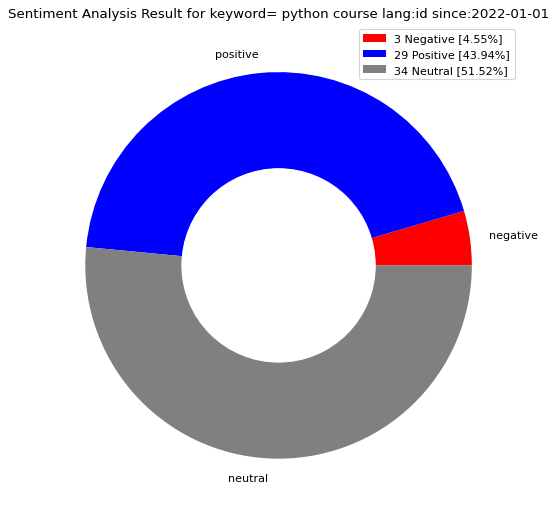

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Bootcamp Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "bootcamp python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_bootcamppython.csv')

In [ ]:
url='https://drive.google.com/file/d/12Ba43ZdP57jTvTf1cymR8H3D27eE7_rr/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "bootcamp python lang:id since:2022-01-01"

bootcampPython = pd.read_csv(file_name)
bootcampPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-18 15:00:42+00:00,baperless,@chavoriel Iya aku ikut bootcamp ml walau logi...
1,1,2022-04-16 10:56:25+00:00,FSyah1111,@fairywoodpprink Bantu jawab ya kak. Gw sender...
2,2,2022-04-16 08:25:33+00:00,gumilangtama,@Yayaya4858859 @worksfess Iya bener aku juga p...
3,3,2022-04-09 16:02:48+00:00,ougustaaz,@cahyadi_es Yang gamau kalah sama bocah 12 tah...
4,4,2022-04-06 10:32:04+00:00,hacktiv8id,Sekarang kesempatan kamu buat nyusul mereka de...


In [ ]:
bootcampPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24 non-null     int64 
 1   Date        24 non-null     object
 2   User        24 non-null     object
 3   Tweet       24 non-null     object
dtypes: int64(1), object(3)
memory usage: 896.0+ bytes


In [ ]:
tw_list = bootcampPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-18 15:00:42+00:00,baperless,iya aku ikut bootcamp ml walau logicku belum ...,@chavoriel Iya aku ikut bootcamp ml walau logi...
1,1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,@fairywoodpprink Bantu jawab ya kak. Gw sender...
2,2,2022-04-16 08:25:33+00:00,gumilangtama,iya bener aku juga pernah ikut tapi ga keter...,@Yayaya4858859 @worksfess Iya bener aku juga p...
3,3,2022-04-09 16:02:48+00:00,ougustaaz,"yang gamau kalah sama bocah 12 tahun, nih men...",@cahyadi_es Yang gamau kalah sama bocah 12 tah...
4,4,2022-04-06 10:32:04+00:00,hacktiv8id,sekarang kesempatan kamu buat nyusul mereka de...,Sekarang kesempatan kamu buat nyusul mereka de...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-18 15:00:42+00:00,baperless,iya aku ikut bootcamp ml walau logicku belum ...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,0.333333,0.375,neutral,0.0,1.000,0.000,0.0000
2,2022-04-16 08:25:33+00:00,gumilangtama,iya bener aku juga pernah ikut tapi ga keter...,0.000000,0.000,positive,0.0,0.920,0.080,0.4215
3,2022-04-09 16:02:48+00:00,ougustaaz,"yang gamau kalah sama bocah 12 tahun, nih men...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-06 10:32:04+00:00,hacktiv8id,sekarang kesempatan kamu buat nyusul mereka de...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
5,2022-03-27 21:54:39+00:00,akiramenna98,"aku melok bootcamp nde data bangalore, gak k...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
6,2022-02-23 01:38:07+00:00,aiyangxiao,"iseng-iseng nyari bootcamp python, gue kira bi...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
7,2022-02-18 11:20:00+00:00,worksfess,work! ada yang punya info bootcamp seputar sql...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
8,2022-02-14 09:27:41+00:00,dikicuy,"🤠: pengalaman ngoding apa mas diki?\n😀: sql, p...",0.000000,0.000,positive,0.0,0.806,0.194,0.7351
9,2022-02-13 19:11:45+00:00,zikhrul,"tapi balik lagi karena gue gak ada duit, gue n...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-16 08:25:33+00:00,gumilangtama,iya bener aku juga pernah ikut tapi ga keter...,0.0,0.0,positive,0.0,0.920,0.080,0.4215
8,2022-02-14 09:27:41+00:00,dikicuy,"🤠: pengalaman ngoding apa mas diki?\n😀: sql, p...",0.0,0.0,positive,0.0,0.806,0.194,0.7351
17,2022-01-21 00:27:55+00:00,pnsmarley,sedang belajar python juga walaupun cuma dari...,0.0,0.0,positive,0.0,0.886,0.114,0.4019


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
18,2022-01-17 04:38:21+00:00,algonacci,indonesiaai\n\npengen belajar python? ds? ml/d...,0.0,0.0,negative,0.078,0.922,0.0,-0.5362


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-18 15:00:42+00:00,baperless,iya aku ikut bootcamp ml walau logicku belum ...,0.000000,0.000,neutral,0.0,1.0,0.0,0.0
1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,0.333333,0.375,neutral,0.0,1.0,0.0,0.0
3,2022-04-09 16:02:48+00:00,ougustaaz,"yang gamau kalah sama bocah 12 tahun, nih men...",0.000000,0.000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,4.17
positive,4,16.67
neutral,19,79.17


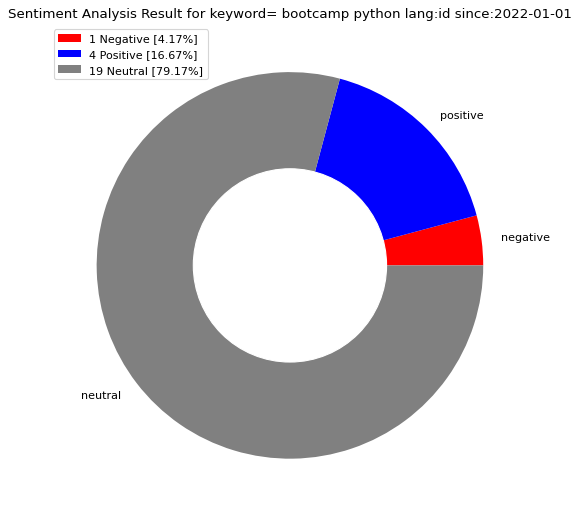

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Training Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "training python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_trainingpython.csv')

In [ ]:
url='https://drive.google.com/file/d/11eVhgjtJlk9UPkoSxrfPIX1_hFBDBDwc/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "training python lang:id since:2022-01-01"

trainingPython = pd.read_csv(file_name)
trainingPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-11 08:52:27+00:00,saptrainingm,SAP Training Marathahalli \nBest SAP FICO | AB...
1,1,2022-04-02 22:10:28+00:00,remote_dev_jobs,"Data Engineer at Betterup, Inc. #Advocate #BI ..."
2,2,2022-03-29 20:01:24+00:00,lenedelr,c++ belajar since matriks then uitm first sem ...
3,3,2022-03-23 02:01:36+00:00,zeddleer,Bosannya python training hshsh smpai jam 1 lgi...
4,4,2022-03-05 19:10:28+00:00,remote_dev_jobs,"Data Engineer at Betterup, Inc. #Advocate #BI ..."


In [ ]:
trainingPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 
 1   Date        10 non-null     object
 2   User        10 non-null     object
 3   Tweet       10 non-null     object
dtypes: int64(1), object(3)
memory usage: 448.0+ bytes


In [ ]:
tw_list = trainingPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-11 08:52:27+00:00,saptrainingm,sap training marathahalli \nbest sap fico | ab...,SAP Training Marathahalli \nBest SAP FICO | AB...
1,1,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...","Data Engineer at Betterup, Inc. #Advocate #BI ..."
2,2,2022-03-29 20:01:24+00:00,lenedelr,c++ belajar since matriks then uitm first sem ...,c++ belajar since matriks then uitm first sem ...
3,3,2022-03-23 02:01:36+00:00,zeddleer,bosannya python training hshsh smpai jam 1 lgi...,Bosannya python training hshsh smpai jam 1 lgi...
4,4,2022-03-05 19:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...","Data Engineer at Betterup, Inc. #Advocate #BI ..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-11 08:52:27+00:00,saptrainingm,sap training marathahalli \nbest sap fico | ab...,1.00,0.300000,positive,0.0,0.851,0.149,0.6369
1,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.00,0.000000,neutral,0.0,1.000,0.000,0.0000
2,2022-03-29 20:01:24+00:00,lenedelr,c++ belajar since matriks then uitm first sem ...,0.25,0.333333,neutral,0.0,1.000,0.000,0.0000
3,2022-03-23 02:01:36+00:00,zeddleer,bosannya python training hshsh smpai jam 1 lgi...,0.00,0.000000,neutral,0.0,1.000,0.000,0.0000
4,2022-03-05 19:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.00,0.000000,neutral,0.0,1.000,0.000,0.0000
5,2022-02-11 14:50:25+00:00,CloudDoor1,#clouddoor #clouddoor melanjutkan soal ini. se...,0.00,0.000000,neutral,0.0,1.000,0.000,0.0000
6,2022-02-11 13:50:25+00:00,CloudDoor1,#clouddoor melanjutkan soal ini. sekarang suda...,0.75,1.000000,positive,0.0,0.932,0.068,0.3400
7,2022-02-11 13:28:36+00:00,aria_ghora,melanjutkan soal ini. sekarang sudah bisa sync...,0.75,1.000000,positive,0.0,0.930,0.070,0.3400
8,2022-01-23 15:50:51+00:00,jowobritish,"jadi w lagi belajar artificial intelligence, n...",-0.60,1.000000,positive,0.0,0.928,0.072,0.4767
9,2022-01-17 06:08:28+00:00,adham_dehe,dulu saya cuba apply kerja dkt kilang. saya l...,0.00,0.000000,neutral,0.0,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-11 08:52:27+00:00,saptrainingm,sap training marathahalli \nbest sap fico | ab...,1.00,0.3,positive,0.0,0.851,0.149,0.6369
6,2022-02-11 13:50:25+00:00,CloudDoor1,#clouddoor melanjutkan soal ini. sekarang suda...,0.75,1.0,positive,0.0,0.932,0.068,0.3400
7,2022-02-11 13:28:36+00:00,aria_ghora,melanjutkan soal ini. sekarang sudah bisa sync...,0.75,1.0,positive,0.0,0.930,0.070,0.3400


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.00,0.000000,neutral,0.0,1.0,0.0,0.0
2,2022-03-29 20:01:24+00:00,lenedelr,c++ belajar since matriks then uitm first sem ...,0.25,0.333333,neutral,0.0,1.0,0.0,0.0
3,2022-03-23 02:01:36+00:00,zeddleer,bosannya python training hshsh smpai jam 1 lgi...,0.00,0.000000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,4,40.0
neutral,6,60.0


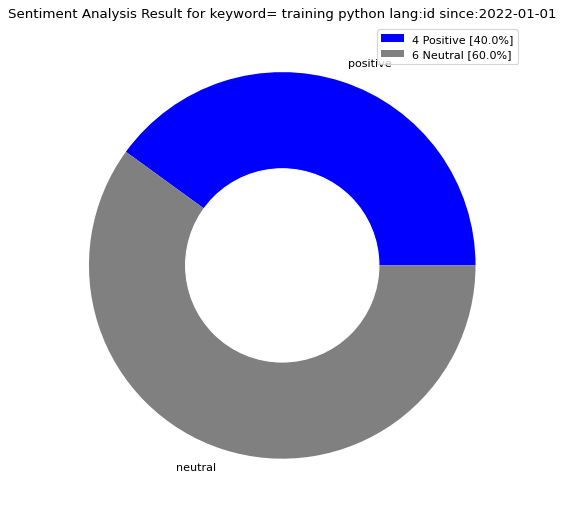

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']

pos = pc['Total']['positive']
neu = pc['Total']['neutral']

names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(pos)+' Positive ['+str(positive)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kelas Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "kelas python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kelaspython.csv')

In [ ]:
url='https://drive.google.com/file/d/18BWF_5vd2B_T7RK2aRtMq61LDvT7a34d/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kelas python lang:id since:2022-01-01"

kelasPython = pd.read_csv(file_name)
kelasPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-10 03:54:31+00:00,vintag3sounds,ini juga nih masih pada sd kisaran kelas 5 dan...
1,1,2022-04-09 13:27:13+00:00,sulistiyares,dulu gua waktu belajar kelas python terus awal...
2,2,2022-04-07 18:01:40+00:00,darefatir,"Woww, really looking forward, Pacmin!🥰 indeed ..."
3,3,2022-04-06 10:32:04+00:00,hacktiv8id,Sekarang kesempatan kamu buat nyusul mereka de...
4,4,2022-04-05 12:32:58+00:00,faldibule,@codingfess WPU klo mau bljar web dari awal\nK...


In [ ]:
kelasPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  52 non-null     int64 
 1   Date        52 non-null     object
 2   User        52 non-null     object
 3   Tweet       52 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.8+ KB


In [ ]:
tw_list = kelasPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-10 03:54:31+00:00,vintag3sounds,ini juga nih masih pada sd kisaran kelas 5 dan...,ini juga nih masih pada sd kisaran kelas 5 dan...
1,1,2022-04-09 13:27:13+00:00,sulistiyares,dulu gua waktu belajar kelas python terus awal...,dulu gua waktu belajar kelas python terus awal...
2,2,2022-04-07 18:01:40+00:00,darefatir,"woww, really looking forward, pacmin!🥰 indeed ...","Woww, really looking forward, Pacmin!🥰 indeed ..."
3,3,2022-04-06 10:32:04+00:00,hacktiv8id,sekarang kesempatan kamu buat nyusul mereka de...,Sekarang kesempatan kamu buat nyusul mereka de...
4,4,2022-04-05 12:32:58+00:00,faldibule,wpu klo mau bljar web dari awal\nkelas terbuk...,@codingfess WPU klo mau bljar web dari awal\nK...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-10 03:54:31+00:00,vintag3sounds,ini juga nih masih pada sd kisaran kelas 5 dan...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
1,2022-04-09 13:27:13+00:00,sulistiyares,dulu gua waktu belajar kelas python terus awal...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
2,2022-04-07 18:01:40+00:00,darefatir,"woww, really looking forward, pacmin!🥰 indeed ...",0.1,0.1625,negative,0.064,0.936,0.000,-0.3382
3,2022-04-06 10:32:04+00:00,hacktiv8id,sekarang kesempatan kamu buat nyusul mereka de...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
4,2022-04-05 12:32:58+00:00,faldibule,wpu klo mau bljar web dari awal\nkelas terbuk...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
5,2022-04-03 08:33:12+00:00,gavrillamahdi,banyak ko di yt yang gratis. kalo mau yang in...,0.0,0.0000,positive,0.000,0.952,0.048,0.0516
6,2022-04-02 15:43:22+00:00,hapidzf21,menggunakan kelas data untuk konfigurasi denga...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
7,2022-04-02 04:50:13+00:00,baterusco,jadwal kelas python hari ini belajar materi te...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
8,2022-04-01 07:36:37+00:00,hapidzf21,cara membangun kelas yang sebanding dengan pyt...,0.0,0.0000,neutral,0.000,1.000,0.000,0.0000
9,2022-03-27 13:43:50+00:00,benimaru____,nyambi kelas python dan sql ya pacmin? haha,0.2,0.3000,positive,0.000,0.700,0.300,0.4588


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
5,2022-04-03 08:33:12+00:00,gavrillamahdi,banyak ko di yt yang gratis. kalo mau yang in...,0.0,0.0,positive,0.0,0.952,0.048,0.0516
9,2022-03-27 13:43:50+00:00,benimaru____,nyambi kelas python dan sql ya pacmin? haha,0.2,0.3,positive,0.0,0.700,0.300,0.4588
11,2022-03-18 07:04:59+00:00,muhdaniellll,sem ni belajar python. harap okay la. dahla ke...,0.5,0.5,positive,0.0,0.872,0.128,0.2263


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-07 18:01:40+00:00,darefatir,"woww, really looking forward, pacmin!🥰 indeed ...",0.10,0.1625,negative,0.064,0.936,0.0,-0.3382
38,2022-01-28 14:51:55+00:00,rizkybprasetyo,banyak bgt yg harus dilakuin malem ini :(\nlen...,-0.75,1.0000,negative,0.139,0.861,0.0,-0.4404


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-10 03:54:31+00:00,vintag3sounds,ini juga nih masih pada sd kisaran kelas 5 dan...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-09 13:27:13+00:00,sulistiyares,dulu gua waktu belajar kelas python terus awal...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,2022-04-06 10:32:04+00:00,hacktiv8id,sekarang kesempatan kamu buat nyusul mereka de...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,2,3.85
positive,13,25.00
neutral,37,71.15


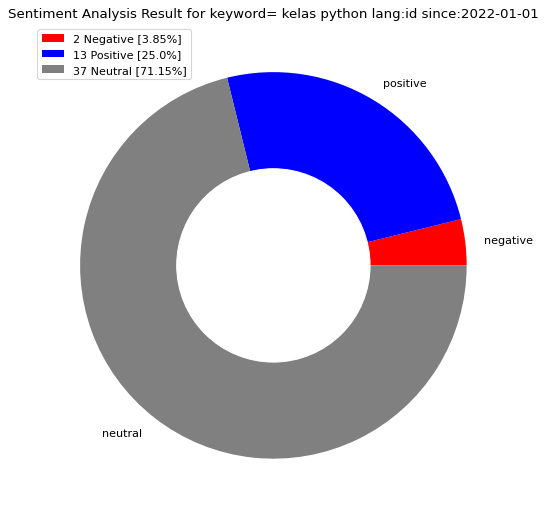

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Les Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "les python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_lespython.csv')

In [ ]:
url='https://drive.google.com/file/d/13zaY76H0CDgpBN8MTbN3LqSGJksq9lFy/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "les python lang:id since:2022-01-01"

lesPython = pd.read_csv(file_name)
lesPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-14 16:42:11+00:00,mjlove0214,ada gak sih tepat les python yg beneran bisa b...
1,1,2022-04-11 15:03:44+00:00,Saefullloh,"Meanwhile lagi les bahasa Jepang, pengen ngamb..."
2,2,2022-04-09 20:42:20+00:00,RemidiKamal,@walidnb17 Makaynsh mouchkil wakha ykon endk m...
3,3,2022-04-01 02:26:05+00:00,Jokitugsfess,joktug! ada yang open les python tentang hash ...
4,4,2022-03-16 14:09:30+00:00,Jokitugsfess,"joktug! serius mau nanya, apa ada yang buka le..."


In [ ]:
lesPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7 non-null      int64 
 1   Date        7 non-null      object
 2   User        7 non-null      object
 3   Tweet       7 non-null      object
dtypes: int64(1), object(3)
memory usage: 352.0+ bytes


In [ ]:
tw_list = lesPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-14 16:42:11+00:00,mjlove0214,ada gak sih tepat les python yg beneran bisa b...,ada gak sih tepat les python yg beneran bisa b...
1,1,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...","Meanwhile lagi les bahasa Jepang, pengen ngamb..."
2,2,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,@walidnb17 Makaynsh mouchkil wakha ykon endk m...
3,3,2022-04-01 02:26:05+00:00,Jokitugsfess,joktug! ada yang open les python tentang hash ...,joktug! ada yang open les python tentang hash ...
4,4,2022-03-16 14:09:30+00:00,Jokitugsfess,"joktug! serius mau nanya, apa ada yang buka le...","joktug! serius mau nanya, apa ada yang buka le..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-14 16:42:11+00:00,mjlove0214,ada gak sih tepat les python yg beneran bisa b...,0.00,0.0,neutral,0.000,1.000,0.000,0.0000
1,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...",-0.75,1.0,neutral,0.000,1.000,0.000,0.0000
2,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,0.00,0.0,neutral,0.000,1.000,0.000,0.0000
3,2022-04-01 02:26:05+00:00,Jokitugsfess,joktug! ada yang open les python tentang hash ...,0.00,0.5,negative,0.166,0.834,0.000,-0.3382
4,2022-03-16 14:09:30+00:00,Jokitugsfess,"joktug! serius mau nanya, apa ada yang buka le...",0.00,0.0,neutral,0.000,1.000,0.000,0.0000
5,2022-02-20 10:12:39+00:00,mcflurrywifey,yay or nay ikut les python buat nambah skill b...,0.00,0.0,positive,0.000,0.726,0.274,0.5267
6,2022-01-11 19:33:22+00:00,Adhit1312W,mau les python tapi dah les kalkulus 💻,0.00,0.0,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
5,2022-02-20 10:12:39+00:00,mcflurrywifey,yay or nay ikut les python buat nambah skill b...,0.0,0.0,positive,0.0,0.726,0.274,0.5267


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-04-01 02:26:05+00:00,Jokitugsfess,joktug! ada yang open les python tentang hash ...,0.0,0.5,negative,0.166,0.834,0.0,-0.3382


In [ ]:
tw_list_neutral.head(5)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-14 16:42:11+00:00,mjlove0214,ada gak sih tepat les python yg beneran bisa b...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...",-0.75,1.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
4,2022-03-16 14:09:30+00:00,Jokitugsfess,"joktug! serius mau nanya, apa ada yang buka le...",0.00,0.0,neutral,0.0,1.0,0.0,0.0
6,2022-01-11 19:33:22+00:00,Adhit1312W,mau les python tapi dah les kalkulus 💻,0.00,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,14.29
positive,1,14.29
neutral,5,71.43


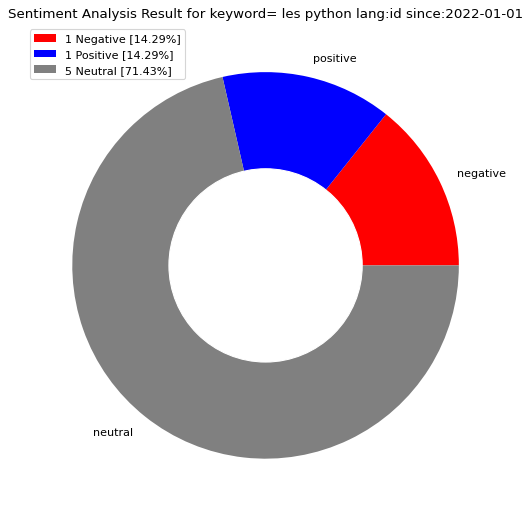

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Pelatihan Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "pelatihan python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_pelatihanpython.csv')

In [ ]:
url='https://drive.google.com/file/d/1OXcNoi0ml6JDqfP6X6gbwKG9uI5fnVM9/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "pelatihan python lang:id since:2022-01-01"

pelatihanPython = pd.read_csv(file_name)
pelatihanPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-14 03:57:12+00:00,oceanmoonskies,@koalakimtae iya kampret bgt 2 minggu berturut...
1,1,2022-04-12 23:17:24+00:00,agusk2010,Pelatihan Data Science dan Machine Learning De...
2,2,2022-04-11 05:25:39+00:00,Dilatihdotco,"Pada pelatihan ini, Anda akan dituntun untuk m..."
3,3,2022-04-09 14:02:49+00:00,moonphasey,@szniffle gua sok kepinteran ambil pelatihan b...
4,4,2022-04-07 06:42:13+00:00,ashnuu,"Udah pelatihan cisco python jalan 2bulan, kok ..."


In [ ]:
pelatihanPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14 non-null     int64 
 1   Date        14 non-null     object
 2   User        14 non-null     object
 3   Tweet       14 non-null     object
dtypes: int64(1), object(3)
memory usage: 576.0+ bytes


In [ ]:
tw_list = pelatihanPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-14 03:57:12+00:00,oceanmoonskies,iya kampret bgt 2 minggu berturut2 pelatihan ...,@koalakimtae iya kampret bgt 2 minggu berturut...
1,1,2022-04-12 23:17:24+00:00,agusk2010,pelatihan data science dan machine learning de...,Pelatihan Data Science dan Machine Learning De...
2,2,2022-04-11 05:25:39+00:00,Dilatihdotco,"pada pelatihan ini, anda akan dituntun untuk m...","Pada pelatihan ini, Anda akan dituntun untuk m..."
3,3,2022-04-09 14:02:49+00:00,moonphasey,gua sok kepinteran ambil pelatihan buat pytho...,@szniffle gua sok kepinteran ambil pelatihan b...
4,4,2022-04-07 06:42:13+00:00,ashnuu,"udah pelatihan cisco python jalan 2bulan, kok ...","Udah pelatihan cisco python jalan 2bulan, kok ..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-14 03:57:12+00:00,oceanmoonskies,iya kampret bgt 2 minggu berturut2 pelatihan ...,0.0,0.00,neutral,0.0,1.000,0.000,0.0000
1,2022-04-12 23:17:24+00:00,agusk2010,pelatihan data science dan machine learning de...,0.0,0.00,neutral,0.0,1.000,0.000,0.0000
2,2022-04-11 05:25:39+00:00,Dilatihdotco,"pada pelatihan ini, anda akan dituntun untuk m...",0.0,0.00,neutral,0.0,1.000,0.000,0.0000
3,2022-04-09 14:02:49+00:00,moonphasey,gua sok kepinteran ambil pelatihan buat pytho...,0.0,0.00,positive,0.0,0.859,0.141,0.3182
4,2022-04-07 06:42:13+00:00,ashnuu,"udah pelatihan cisco python jalan 2bulan, kok ...",0.0,0.00,neutral,0.0,1.000,0.000,0.0000
5,2022-04-06 11:02:40+00:00,ASMATUNDIP,"pelatihan internal kali ini mengangkat tema ""g...",0.0,0.00,neutral,0.0,1.000,0.000,0.0000
6,2022-04-05 15:01:58+00:00,byhanagao,aku dulu ikut pelatihan python sama game des...,-0.2,0.20,positive,0.0,0.928,0.072,0.4215
7,2022-04-03 05:21:31+00:00,dairxy,trus coba ikut pelatihan aja. taun kemaren di...,0.0,0.00,neutral,0.0,1.000,0.000,0.0000
8,2022-03-07 02:15:31+00:00,ciput_chan,padahal dulu waktu pengumuman libur 2 minggu p...,0.5,0.35,positive,0.0,0.746,0.254,0.7783
9,2022-02-27 03:55:11+00:00,Dihajjaraja,masih bingungg mau pilih pelatihan digitalent ...,0.0,0.00,neutral,0.0,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-04-09 14:02:49+00:00,moonphasey,gua sok kepinteran ambil pelatihan buat pytho...,0.0,0.00,positive,0.0,0.859,0.141,0.3182
6,2022-04-05 15:01:58+00:00,byhanagao,aku dulu ikut pelatihan python sama game des...,-0.2,0.20,positive,0.0,0.928,0.072,0.4215
8,2022-03-07 02:15:31+00:00,ciput_chan,padahal dulu waktu pengumuman libur 2 minggu p...,0.5,0.35,positive,0.0,0.746,0.254,0.7783


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
13,2022-01-19 09:46:38+00:00,seblakcyekerr,tugas pelatihan gue bisa kelar sblm closing bs...,0.0,0.0,negative,0.116,0.884,0.0,-0.3612


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-14 03:57:12+00:00,oceanmoonskies,iya kampret bgt 2 minggu berturut2 pelatihan ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-12 23:17:24+00:00,agusk2010,pelatihan data science dan machine learning de...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-11 05:25:39+00:00,Dilatihdotco,"pada pelatihan ini, anda akan dituntun untuk m...",0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,7.14
positive,4,28.57
neutral,9,64.29


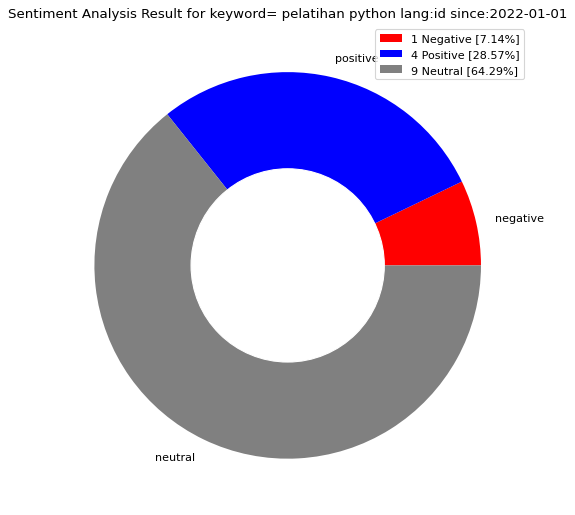

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Belajar Python**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "belajar python lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_belajarpython.csv')

In [ ]:
url='https://drive.google.com/file/d/1uwRXOhOpNUok3KBLY4zvQYA9XxdrKlsM/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "belajar python lang:id since:2022-01-01"

belajarPython = pd.read_csv(file_name)
belajarPython.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 15:42:45+00:00,codingfess,mending belajar Java dlu ato python ya? code;
1,1,2022-04-19 14:21:42+00:00,Ebedkm,CSES 1633 dicoba pake python dp top down maupu...
2,2,2022-04-19 08:59:46+00:00,DQLab_id,"Ngabuburit beli nasi uduk, belajar Python lebi..."
3,3,2022-04-19 08:15:06+00:00,DewaBizMedia,Tips Belajar Python dengan Mudah dan Cepat unt...
4,4,2022-04-19 06:25:32+00:00,sincosdxdy,@asmurcom @worksfess wah udh two days ago. apa...


In [ ]:
belajarPython.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  590 non-null    int64 
 1   Date        590 non-null    object
 2   User        590 non-null    object
 3   Tweet       590 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.6+ KB


In [ ]:
tw_list = belajarPython

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 15:42:45+00:00,codingfess,mending belajar java dlu ato python ya? code;,mending belajar Java dlu ato python ya? code;
1,1,2022-04-19 14:21:42+00:00,Ebedkm,cses 1633 dicoba pake python dp top down maupu...,CSES 1633 dicoba pake python dp top down maupu...
2,2,2022-04-19 08:59:46+00:00,DQLab_id,"ngabuburit beli nasi uduk, belajar python lebi...","Ngabuburit beli nasi uduk, belajar Python lebi..."
3,3,2022-04-19 08:15:06+00:00,DewaBizMedia,tips belajar python dengan mudah dan cepat unt...,Tips Belajar Python dengan Mudah dan Cepat unt...
4,4,2022-04-19 06:25:32+00:00,sincosdxdy,wah udh two days ago. apakah masih open bang...,@asmurcom @worksfess wah udh two days ago. apa...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 15:42:45+00:00,codingfess,mending belajar java dlu ato python ya? code;,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,2022-04-19 14:21:42+00:00,Ebedkm,cses 1633 dicoba pake python dp top down maupu...,0.172222,0.394444,positive,0.074,0.820,0.107,0.0516
2,2022-04-19 08:59:46+00:00,DQLab_id,"ngabuburit beli nasi uduk, belajar python lebi...",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
3,2022-04-19 08:15:06+00:00,DewaBizMedia,tips belajar python dengan mudah dan cepat unt...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
4,2022-04-19 06:25:32+00:00,sincosdxdy,wah udh two days ago. apakah masih open bang...,0.000000,0.312500,neutral,0.000,1.000,0.000,0.0000
5,2022-04-19 05:59:28+00:00,adibamhsn,aku tampamham bethol kenapa kena belajar pytho...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
6,2022-04-18 11:58:17+00:00,hanaccia,"rekomen banget karena bakal selalu kepake, ak...",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
7,2022-04-18 11:55:00+00:00,moonareas,☁️ hi! jadi sender mau mulai belajar pemrogram...,0.000000,0.000000,positive,0.000,0.825,0.175,0.6421
8,2022-04-18 01:14:23+00:00,banyurachman,notepad++ 😄 🤣 \n\nterus dikenalin sublime sama...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
9,2022-04-17 18:18:07+00:00,gitpuut,"belajar golang, python aja wkwkwkkwk",0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-19 14:21:42+00:00,Ebedkm,cses 1633 dicoba pake python dp top down maupu...,0.172222,0.394444,positive,0.074,0.820,0.107,0.0516
7,2022-04-18 11:55:00+00:00,moonareas,☁️ hi! jadi sender mau mulai belajar pemrogram...,0.000000,0.000000,positive,0.000,0.825,0.175,0.6421
10,2022-04-17 16:15:57+00:00,sogasagu,portfolio project #1 udah jadi 🥳🥳\nkali ini be...,0.000000,0.000000,positive,0.000,0.903,0.097,0.4588


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
13,2022-04-17 08:44:59+00:00,tsunder12835345,"kak sorry tanya di sini, selama belajar mandi...",-0.5,1.0,negative,0.064,0.936,0.0,-0.0772
27,2022-04-16 08:08:56+00:00,orfeokyoong,"gue belajar python satu semester cuma paham ""...",-0.5,1.0,negative,0.237,0.763,0.0,-0.4767
61,2022-04-11 06:27:04+00:00,codingfess,code; saya dalam tahap belajar python niatnya ...,0.0,0.0,negative,0.044,0.956,0.0,-0.2500


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 15:42:45+00:00,codingfess,mending belajar java dlu ato python ya? code;,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-19 08:59:46+00:00,DQLab_id,"ngabuburit beli nasi uduk, belajar python lebi...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,2022-04-19 08:15:06+00:00,DewaBizMedia,tips belajar python dengan mudah dan cepat unt...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,32,5.42
positive,131,22.20
neutral,427,72.37


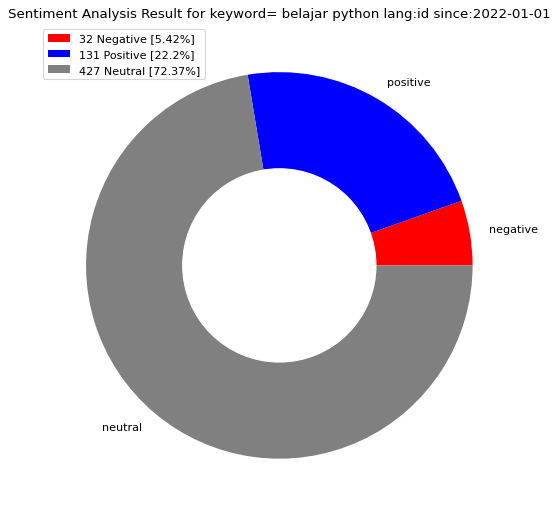

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()